In [1]:
import pandas as pd

In [2]:
norm_rates_file = 'bpm_norm_rates.csv'
data = pd.read_csv(norm_rates_file)

print(data.head())

   ID        Date   Time Range  BPM min  BPM max   Condition
0   1  2024-10-01  09:00-10:00       96      118      normal
1   2  2024-10-01  11:00-12:00       83      108      normal
2   3  2024-10-01  14:00-15:00       83      117      normal
3   4  2024-10-05  11:00-12:00       88      130  exercising
4   5  2024-10-05  12:00-13:00       78      108      normal


In [3]:
print(data.tail())

     ID        Date   Time Range  BPM min  BPM max Condition
94   96  2024-10-11  03:00-04:00       54       62   resting
95   97  2024-10-11  04:00-05:00       54       59   resting
96   98  2024-10-11  05:00-06:00       55       87   resting
97   99  2024-10-04  12:00-13:00       69       85    normal
98  100  2024-10-04  13:00-14:00       67       93    normal


In [3]:
# Extracting BPM min and BPM max columns
bpm_min = data['BPM min']
bpm_max = data['BPM max']

# Display the first few entries of each
print(f'BPM min: {bpm_min.head()}')
print(f'BPM max: {bpm_max.head()}')

BPM min: 0    96
1    83
2    83
3    88
4    78
Name: BPM min, dtype: int64
BPM max: 0    118
1    108
2    117
3    130
4    108
Name: BPM max, dtype: int64


## Usage BPM Min and Max Values

Depending on what you need these values for, there are several operations you might consider:

1. Statistical Analysis: You can compute statistical values such as the average, median, standard deviation, etc., for these BPM rates.
2. Visualizing Data: You might want to plot these BPM rates to see trends or outliers.
python
3. Further Data Processing: If you are preparing to use these BPM rates for machine learning or more detailed analysis, you might want to filter, normalize, or scale these values based on your requirements.
4. Correlation Analysis: Determine if there's a correlation between the minimum and maximum BPM rates or with other variables in your dataset.

In [4]:
# 1. Statistical Analysis: You can compute statistical values such as the average, median, standard deviation, etc., for these BPM rates.

print("Statistics for BPM Min:")
print(bpm_min.describe())

print("\nStatistics for BPM Max:")
print(bpm_max.describe())

Statistics for BPM Min:
count    23.000000
mean     71.869565
std      14.088372
min      50.000000
25%      61.500000
50%      71.000000
75%      81.000000
max      98.000000
Name: BPM min, dtype: float64

Statistics for BPM Max:
count     23.000000
mean     101.173913
std       27.859472
min       63.000000
25%       81.000000
50%       98.000000
75%      112.000000
max      179.000000
Name: BPM max, dtype: float64


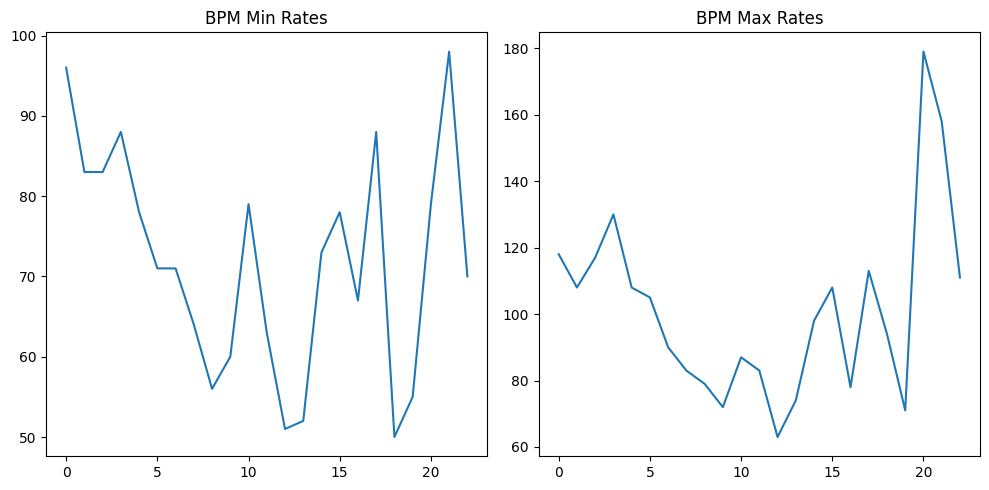

In [5]:
# 2. Visualizing Data: You might want to plot these BPM rates to see trends or outliers.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bpm_min.plot(title='BPM Min Rates')
plt.subplot(1, 2, 2)
bpm_max.plot(title='BPM Max Rates')
plt.tight_layout()
plt.show()


In [6]:
# 3. Example: Normalize BPM rates
bpm_min_normalized = (bpm_min - bpm_min.min()) / (bpm_min.max() - bpm_min.min())
bpm_max_normalized = (bpm_max - bpm_max.min()) / (bpm_max.max() - bpm_max.min())

print("Normalized BPM Min Rates:")
print(bpm_min_normalized.head())

Normalized BPM Min Rates:
0    0.958333
1    0.687500
2    0.687500
3    0.791667
4    0.583333
Name: BPM min, dtype: float64


In [7]:
# Correlation Analysis

correlation = data[['BPM min', 'BPM max']].corr()
print("Correlation between BPM Min and Max:")
print(correlation)


Correlation between BPM Min and Max:
          BPM min   BPM max
BPM min  1.000000  0.745641
BPM max  0.745641  1.000000


In [2]:
import pandas as pd

# Load your data
data = pd.read_csv('C:/Users/benz/SynologyDrive/PycharmProjects/ToxitracAI/datasets/bpm_norm_rates.csv')

# Assuming 'Time Range' is in the format 'HH:MM-HH:MM'
# Split 'Time Range' into 'start_time' and 'end_time'
data[['start_time', 'end_time']] = data['Time Range'].str.split('-', expand=True)

# Convert these new columns into datetime format
data['start_time'] = pd.to_datetime(data['start_time'], format='%H:%M').dt.time
data['end_time'] = pd.to_datetime(data['end_time'], format='%H:%M').dt.time

# Now you can work with these datetime objects
print(data[['start_time', 'end_time']].head())


  start_time  end_time
0   09:00:00  10:00:00
1   11:00:00  12:00:00
2   14:00:00  15:00:00
3   11:00:00  12:00:00
4   12:00:00  13:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pywt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from joblib import dump

# Load your data
data = pd.read_csv('C:/Users/benz/SynologyDrive/PycharmProjects/ToxitracAI/datasets/bpm_norm_rates.csv')

def map_condition(condition):
    """A function that map different conditions to normal or active"""
    if condition in ['normal', 'resting']:
        return 'normal'
    else:
        return 'active'

data['Category'] = data['Condition'].apply(map_condition)
label_encoder = LabelEncoder()
data['Category'] = label_encoder.fit_transform(data['Category'])

data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Process Time Range into datetime
data[['start_time', 'end_time']] = data['Time Range'].str.split('-', expand=True)
data['start_time'] = pd.to_datetime(data['start_time'], format='%H:%M')
data['end_time'] = pd.to_datetime(data['end_time'], format='%H:%M')
data['duration_hours'] = (data['end_time'] - data['start_time']).dt.seconds / 3600

# Convert BPM values to numerics and normalize
data['BPM min'] = pd.to_numeric(data['BPM min'], errors='coerce')
data['BPM max'] = pd.to_numeric(data['BPM max'], errors='coerce')
scaler = StandardScaler()
data[['BPM min', 'BPM max']] = scaler.fit_transform(data[['BPM min', 'BPM max']])

In [3]:
# First, ensure 'BPM min' and 'BPM max' do not contain NaNs for DWT transformation
mask = data['BPM min'].notna() & data['BPM max'].notna()
print(f'Display mask data:\n{mask.head()}')
data_filtered = data[mask]
print(f'Display filtered data:\n{data_filtered.head()}')


Display mask data:
0    True
1    True
2    True
3    True
4    True
dtype: bool
Display filtered data:
   ID       Date   Time Range   BPM min   BPM max   Condition  Category  Year  \
0   1 2024-10-01  09:00-10:00  1.430191  0.159142      normal         1  2024   
1   2 2024-10-01  11:00-12:00  0.598685 -0.141126      normal         1  2024   
2   3 2024-10-01  14:00-15:00  0.598685  0.129115      normal         1  2024   
3   4 2024-10-05  11:00-12:00  0.918495  0.519463  exercising         0  2024   
4   5 2024-10-05  12:00-13:00  0.278875 -0.141126      normal         1  2024   

   Month  Day          start_time            end_time  duration_hours  
0     10    1 1900-01-01 09:00:00 1900-01-01 10:00:00             1.0  
1     10    1 1900-01-01 11:00:00 1900-01-01 12:00:00             1.0  
2     10    1 1900-01-01 14:00:00 1900-01-01 15:00:00             1.0  
3     10    5 1900-01-01 11:00:00 1900-01-01 12:00:00             1.0  
4     10    5 1900-01-01 12:00:00 1900-01-01 13:0

In [4]:
# Recalculate DWT features on filtered data
cA_min, _ = pywt.dwt(data_filtered['BPM min'].values, 'db1')
cA_max, _ = pywt.dwt(data_filtered['BPM max'].values, 'db1')

data_filtered = data_filtered.iloc[:len(cA_min)]  # Adjust the dataframe to match the DWT output length

# Ensure that the number of samples in your features and labels are identical
# Now prepare your feature set
X_filtered = data_filtered[['BPM min', 'BPM max']]
X_stacked = np.column_stack((X_filtered, cA_min, cA_max))
y_filtered = data_filtered['Category']

# Now, X_stacked and y_filtered can be used for splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_stacked, y_filtered, test_size=0.4, random_state=42)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

print(model.score(X_test, y_test))  # Score method measures the accuracy of the model predictions

0.9


In [5]:
from sklearn.metrics import log_loss

# Predict probabilities on the test set
prob_predictions = model.predict(X_test)

# Calculate the log loss
loss = log_loss(y_test, prob_predictions)
print(loss)

3.604365338911715
